# Exploratory Data Analysis - Cleaning

1. **[Work with missing data in a Python notebook](#missing)**
2. **[Example Address Missing Data Unicorn Companies](#unicorn)**
    - **[Mask](#masking)**

<a id='missing'></a>
# Work with missing data in a Python notebook

In this notebook, we will be discovering and working with missing data on a dataset. 

## Objective

We will be examining lightning strike data collected by the National Oceanic and Atmospheric Association (NOAA) for the month of August 2018. There are two datasets. The first includes five columns:  

|date|center_point_geom|longitude|latitude|number_of_strikes|
|---|---|---|---|---|

The second dataset contains seven columns:

|date|zip_code|city|state|state_code|center_point_geom|number_of_strikes|
|---|---|---|---|---|---|---|  

The first dataset has two unique colums: `longitude` and `latitude`.  
The second dataset has four unique columns: `zip_code`, `city`, `state`, and `state_code`.  
There are three columns that are common between them: `date`, `center_point_geom`, and `number_of_strikes`.

We want to combine the two datasets into a single dataframe that has all of the information from both datasets. Ideally, both datasets will have the same number of entries for the same locations on the same dates. If they don't, we'll investigate which data is missing.

In [ ]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

In [ ]:
# Read in first dataset
df = pd.read_csv('datasets/eda_missing_data_dataset1.csv')

# Print the first 5 rows of dataset 1
df.head()


In [ ]:
df.shape

In [ ]:
# Read in second dataset
df_zip = pd.read_csv('datasets/eda_missing_data_dataset2.csv')

# Print the first 5 rows of dataset 2
df_zip.head()

In [ ]:
# check shape of new dataset 
df_zip.shape

This dataset has less than half the number of rows as the first one. But which ones are they?  

The first thing we'll do to explore this discrepancy is join the two datasets into a single dataframe. We can do this using the `merge()` method of the `DataFrame` class. For more information about the `merge()` method, refer to the [merge() pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).  

Begin with the first dataframe (`df`) and call the `merge()` method on it. The first argument is a positional argument that specifies the dataframe we want to merge with, known as the `right` dataframe. (The dataframe you're calling the method on is always the `left` dataframe.) The `how` argument specifies which dataframe's keys we'll use to match to, and the `on` argument lets us define the columns to use as keys. 

In [ ]:
# Left-join the two datasets
df_joined = df.merge(df_zip, how='left', on=['date','center_point_geom'])

# Print the first 5 rows of the merged data
df_joined.head()

Notice that the new dataframe has all of the columns of both original dataframes, and it has two `number_of_strikes` columns that are suffixed with `_x` and `_y`. This is because the key columns from both dataframes were the same, so they appear once in the merged dataframe. The unique columns of each original dataframe also appear in the merged dataframe. But both original dataframes had another column&mdash;`number_of_strikes`&mdash;that had the same name in both dataframes and was not indicated as a key. Pandas handles this by adding both columns to the new dataframe. 

Now, we'll check the summary on this joined dataset.  

In [ ]:
# Get descriptive statistics of the joined dataframe
df_joined.describe()

The count information confirms that the new dataframe is missing some data. 

Now let's check how many missing state locations we have by using `isnull()` to create a Boolean mask that we'll apply to `df_joined`. The mask is a pandas `Series` object that contains `True` for every row with a missing `state_code` value and `False` for every row that is not missing data in this column. When the mask is applied to `df_joined`, it filters out the rows that are not missing `state_code` data. (Note that using the `state_code` column to create this mask is an arbitrary decision. We could have selected `zip_code`, `city`, or `state` instead and gotten the same results.)

In [ ]:
# Create a new df of just the rows that are missing data
df_null_geo = df_joined[pd.isnull(df_joined.state_code)]
df_null_geo.shape

We can confirm that `df_null_geo` contains only the rows with the missing `state_code` values by using the `info()` method on `df_joined` and comparing. 

In [ ]:
# Get non-null counts on merged dataframe
df_joined.info()

If we subtract the 323,700 non-null rows in columns 5-9 of `df_joined` from the 717,530 non-null rows in columns 0-4 of `df_joined`, we're left with 393,830 rows that contain missing data&mdash;the same number of rows contained in `df_null_geo`.

In [ ]:
# Print the first 5 rows
df_null_geo.head()

Now that we've merged all of our data together and isolated the rows with missing data, we can better understand what data is missing by plotting the longitude and latitude of locations that are missing city, state, and zip code data.

In [ ]:
# Create new df of just latitude, longitude, and number of strikes and group by latitude and longitude
top_missing = df_null_geo[['latitude','longitude','number_of_strikes_x']
            ].groupby(['latitude','longitude']
                      ).sum().sort_values('number_of_strikes_x',ascending=False).reset_index()

top_missing.head(10)

Let's import plotly to reduce the size of the data frame as we create a geographic scatter plot. 

In [ ]:
# IMPORT EXPRESS for geo graph
import plotly.express as px  

# reduce size of db otherwise it could break
fig = px.scatter_geo(top_missing[top_missing.number_of_strikes_x>=300],  # Input Pandas DataFrame
                    lat="latitude",  # DataFrame column with latitude
                    lon="longitude",  # DataFrame column with latitude
                    size="number_of_strikes_x") # Set to plot size as number of strikes
fig.update_layout(
    title_text = 'Missing data', # Create a Title
)

fig.show()

It’s a nice geographic visualization, but we really don’t need the global scale. Let’s scale it down to only the geographic area we are interested in - the United States.

**Note:** The following cell's output is viewable in two ways: You can re-run this cell (and all of the ones before it) or manually convert the notebook to "Trusted."

In [ ]:
fig = px.scatter_geo(top_missing[top_missing.number_of_strikes_x>=300],  # Input Pandas DataFrame
                    lat="latitude",  # DataFrame column with latitude
                    lon="longitude",  # DataFrame column with latitude
                    size="number_of_strikes_x") # Set to plot size as number of strikes
fig.update_layout(
    title_text = 'Missing data', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)

fig.show()

This explains why so many rows were missing state and zip code data! Most of these lightning strikes occurred over water&mdash;the Atlantic Ocean, the Sea of Cortez, the Gulf of Mexico, the Caribbean Sea, and the Great Lakes. Of the strikes that occurred over land, most of those were in Mexico, the Bahamas, and Cuba&mdash;places outside of the U.S. and without U.S. zip codes. Nonetheless, some of the missing data is from Florida and elsewhere within the United States, and we might want to ask the database owner about this.

<a id="unicorn"> </a>
# Example Address Missing Data Unicorn Companies

## Introduction

Most datasets that data professionals use to solve problems typically contain missing values, which must be dealt with in order to achieve clean, useful data. This is particularly crucial in exploratory data analysis (EDA). In this activity, you will learn how to address missing data. 

You are a financial data consultant, and an investor has tasked your team with identifying new business opportunities. To help them decide which future companies to invest in, you will provide a list of current businesses valued at more than $1 billion. These are sometimes referred to as "unicorns." Your client will use this information to learn about profitable businesses in general.

The investor has asked you to provide them with the following data: 
- Companies in the `hardware` industry based in `Beijing`, `San Francisco`, and `London` 
- Companies in the `artificial intelligence` industry based in `London`
-  A list of the top 20 countries sorted by sum of company valuations in each country, excluding `United States`, `China`, `India`, and `United Kingdom`
- A global valuation map of all countries except `United States`, `China`, `India`, and `United Kingdom`

Your dataset includes a list of businesses and data points, such as the year they were founded; their industry; and their city, country, and continent. 

In [ ]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime

In [ ]:
# Read the data into a dataframe
df_companies = pd.read_csv('datasets/Unicorn_Companies_Missing.csv')

# Display the first 10 rows of the data.
df_companies.head(10)

### Statistical properties of the dataset

Use methods and attributes of the dataframe to get information and descriptive statistics for the data, including its range, data types, mean values, and shape. 

In [ ]:
# Get the shape of the dataset.
print(df_companies.shape)

# Get the data types and number of non-null values in the dataset.
df_companies.info()

**Question: What is the shape of the dataset?**
- (1074, 10)

**Question: What are the data types of various columns?**
- Except for the `Year Funded` column, which is `int64`, the data type for all other columns is `object`. You can get this information using the `info()` method. 

**Question: How many columns contain null values?**
- Columns `City` and `Select Investors` contain fewer non-null values than the total number of rows in the dataset, which indicates that they are missing values. You can get this information using the `info()` method. 

In [ ]:
# Get descriptive statistics such as mean, standard deviation, and range of the numerical columns in the dataset.
df_companies.describe()

**Question: In what year was the oldest company founded?**
-  The oldest company in the list was founded in 1919. This is the minimum value in `Year Funded`. You can get this information using the `describe()` method. 

### Data Preprocessing

In order to answer the investor's questions, some data preprocessing steps are required. The first step is to add a new column to the dataframe containing just the year each company became a unicorn company. Call this new column `Year Joined`. 

In [ ]:
# Create a new column `Year Joined` 
df_companies['Year_Joined'] = pd.to_datetime(df_companies['Date Joined']).dt.year

For each country, you want to calculate the sum of all valuations of companies from that country. However, in order to do this, you'll need to first prepare the data. Currently, the data in the `Valuation` column is a string that starts with a `$` and ends with a `B`. Because this column is not in a numeric datatype, pandas cannot perform mathematical operations on its values. The data in this column needs to be converted to a numeric datatype. 

In this step, define a function called `str_to_num()` that accepts as an argument:

* `x`: a string in the format of the values contained in the `Valuation` column

And returns:

* `x`: an `int` of the number represented by the input string

```
Example:

 [IN]:  str_to_num('$4B')
[OUT]:  4

```


To do this, use the string [`strip()`](https://docs.python.org/3/library/stdtypes.html#str.strip) method. This method is applied to a string. Its argument is a string that contains all the characters that you want to remove from the beginning and end of a given string&mdash;in any order. The specified characters will be removed until a valid character is encountered. This process is applied moving forward from the beginning of the string and also moving in reverse from the end of the string, thus removing unwanted beginning and trailing characters.

```
Example:

 [IN]:  my_string = '#....... Section 3.2.1 Issue #32 .......'
        my_string = my_string.strip('.#! ')
        print(my_string)

[OUT]:  'Section 3.2.1 Issue #32'

```

Note that you must reassign the result back to a variable or else the change will not be permanent. 

In [ ]:
# Define the `str_to_num()` function
def str_to_num(x):
    x = x.strip('$B')
    x = int(x)

    return x

Now, use this function to create a new column called `valuation_num` that represents the `Valuation` column as an integer value. To do this, use the series method [`apply()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) to apply the `str_to_num()` function to the `Valuation` column.

`apply()` is a method that can be used on a `DataFrame` or `Series` object. In this case, you're using it on the `Valuation` series. The method accepts a function as an argument and applies that function to each value in the series.

```
Example:

 [IN]: def square(x):
           return x ** 2

       my_series = pd.Series([0, 1, 2, 3])
       my_series

[OUT]: 0    0
       1    1
       2    2
       3    3
       dtype: int64

 [IN]: my_series = my_series.apply(square)
       my_series

[OUT]: 0    0
       1    1
       2    4
       3    9
       dtype: int64
```

Notice that the function passed as an argument to the `apply()` method does not have parentheses. It's just the function name.

In [ ]:
# Apply the `str_to_num()` function to the `Valuation` column
# and assign the result back to a new column called `valuation_num`
df_companies['valuation_num'] = df_companies['Valuation'].apply(str_to_num)
df_companies[['Valuation', 'valuation_num']].head()

### Find missing values

The unicorn companies dataset is fairly clean, with few missing values. 

In [ ]:
# Find the number of missing values in each column in this dataset.
df_companies.isna().sum()

**Question: How many missing values are in each column in the dataset?**
- There is a single missing value in the `Select Investors` column and 16 missing cities. There are no missing values in other columns. 

<a id="masking"> </a>
# Mask

### Review rows with missing values

Before dealing with missing values, it's important to understand the nature of the missing value that is being filled. Display all rows with missing values from `df_companies`. To do this, perform the following three steps:

1. Apply the `isna()` method to the `df_companies` dataframe as you did in the last step. Remember, this results in a dataframe of the same shape as `df_companies` where each value is `True` if its contents are `NaN` and a `False` if its contents are not `NaN`. Assign the results to a variable called `mask`.

In [ ]:
# 1. Apply the `isna()` method to the `df_companies` dataframe and assign back to `mask`
mask = df_companies.isna()
mask.tail()

You're not done yet. You still need to go from this dataframe of Boolean values to a dataframe of just the rows of `df_companies` that contain at least one `NaN` value. This means that you need a way to find the indices of the rows of the Boolean dataframe that contain at least one `True` value, then extract those indices from `df_companies`. 

You can do this using the [`any()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.any.html) method for `DataFrame` objects. This method returns a Boolean `Series` indicating whether any value is `True` over a specified axis.

```
Example:

df =     
        A      B    C
    0   0      a    10
    1   False  0    1
    2   NaN    NaN  NaN


 [IN]: df.any(axis=0)

[OUT]: A    False
       B     True
       C     True
       dtype: bool
       
 [IN]: df.any(axis=1)
 
[OUT]: 0     True
       1     True
       2    False
       dtype: bool
```

Note that `0`, `False`, and `NaN` are considered `False` and anything else is considered `True`. 

2. Apply the `any()` method to the Boolean dataframe you created to make a Boolean series where each element in the series represents `True` if a row of the dataframe contains any `True` values and `False` if any row in the dataframe contains any `False` values. Assign the results back to `mask`.

In [ ]:
# 2. Apply the `any()` method to `mask` and assign the results back to `mask`
mask = mask.any(axis=1)
mask.head()

3. Because `mask` is now a series of Boolean values, you can use it as a Boolean mask. Apply the Boolean mask to the `df_companies` dataframe to return a filtered dataframe containing just the rows that contain a missing value. Assign the results to a variable called `df_missing_rows`.

In [ ]:
# 3. Apply `mask` as a Boolean mask to `df_companies` and assign results to `df_missing_rows`
df_missing_rows = df_companies[mask]
df_missing_rows

**Question: Is there a specific country/region that shows up a lot in this missing values dataframe? Which one?**
- Twelve of the 17 rows with missing values are for companies from Singapore.

**Question: What steps did you take to find missing data?**
- `DataFrame.isna()` will return a Boolean dataframe indicating every location that is `NaN` with `True`
- You can use `sum()` in conjunction with `isna()` to get the counts of `NaN` values in each column.
- You can use `any()` in conjunction with `isna()` to create a Boolean mask, which can be applied to the original dataframe to obtain just the rows with at least one `NaN` value.

**Question: What observations can be made about the forms and context of missing data?**
- Missing values can take different forms and are usually context-specific. Not every missing value is labeled as `na` or `None`, or `Null`.

**Question: What other methods could you use to address missing data?**
- If possible, ask the business users for insight into the causes of missing values and, if possible, get domain knowledge to intelligently impute these values.

## Step 3: Model building

Think of the model you are building as the completed dataset, which you will then use to inform the questions the investor has asked of you.  

### Two ways to address missing values

There are several ways to address missing values, which is critical in EDA. The two primary methods are removing them and imputing other values in their place. Choosing the proper method depends on the business problem and the value the solution will add or take away from the dataset.

Here, you will try both. 

To compare the the effect of different actions, first store the original number of values in a variable. Create a variable called `count_total` that is an integer representing the total number of values in `df_companies`. For example, if the dataframe had 5 rows and 2 columns, then this number would be 10.

In [ ]:
# Store the total number of values in a variable called `count_total`
count_total = df_companies.size
count_total

Now, remove all rows containing missing values and store the total number of remaining values in a variable called `count_dropna_rows`.

In [ ]:
# Drop the rows containing missing values, determine number of remaining values 
count_dropna_rows = df_companies.dropna().size
count_dropna_rows

Now, remove all columns containing missing values and store the total number of cells in a variable called `count_dropna_columns`.

In [ ]:
# Drop the columns containing missing values, determine number of remaining values
count_dropna_columns = df_companies.dropna(axis=1).size
count_dropna_columns

Next, print the percentage of values removed by each method and compare them.

In [34]:
# Print the percentage of values removed by dropping rows.
row_percent = ((count_total - count_dropna_rows) / count_total) * 100
print(f'Percentage removed, rows: {row_percent:.3f}')

# Print the percentage of values removed by dropping columns.
col_percent = ((count_total - count_dropna_columns) / count_total) * 100
print(f'Percentage removed, columns: {col_percent:.3f}')

Percentage removed, rows: 1.583
Percentage removed, columns: 16.667


**Question: Which method was most effective? Why?**

The percentage removed was significantly higher for columns than it was for rows. Since both approaches result in a dataset with no missing values, the "most effective" method depends on how much data you have and what you want to do with it. It might be best to use the way that leaves the most data intact&mdash;in this case, dropping rows. Or, if you don't have many samples and don't want to lose any, but you don't need all your columns, then dropping columns might be best. With this data, it would probably be best to drop rows in the majority of cases.

Now, practice the second method: imputation. Perform the following steps:

1. Use the [`fillna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) dataframe method to fill each missing value with the next non-NaN value in its column. Assign the results to a new dataframe called `df_companies_backfill`.

```
Example:

df =     
        A    B    C
    0   5    a    NaN
    1   10   NaN  False
    2   NaN  c    True

 [IN]: df.fillna(method='backfill')
 
[OUT]: 
        A    B    C
    0   5    a    False
    1   10   c    False
    2   NaN  c    True

```

Notice that if there is a `NaN` value in the last row, it will not backfill because there is no subsequent value in the column to refer to. 

2. Show the rows that previously had missing values.

In [35]:
# 1. Fill missing values using the 'fillna()' method, back-filling
df_companies_backfill = df_companies.fillna(method='backfill')

# 2. Show the rows that previously had missing values
df_companies_backfill.iloc[df_missing_rows.index, :]

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors,Year_Joined,valuation_num
12,FTX,$32B,7/20/21,Fintech,Jacksonville,Bahamas,North America,2018,$2B,"Sequoia Capital, Thoma Bravo, Softbank",2021,32
170,HyalRoute,$4B,5/26/20,Mobile & telecommunications,El Segundo,Singapore,Asia,2015,$263M,Kuang-Chi,2020,4
242,Moglix,$3B,5/17/21,E-commerce & direct-to-consumer,San Francisco,Singapore,Asia,2015,$471M,"Jungle Ventures, Accel, Venture Highway",2021,3
251,Trax,$3B,7/22/19,Artificial intelligence,Amsterdam,Singapore,Asia,2010,$1B,"Hopu Investment Management, Boyu Capital, DC T...",2019,3
325,Amber Group,$3B,6/21/21,Fintech,San Francisco,Hong Kong,Asia,2015,$328M,"Tiger Global Management, Tiger Brokers, DCM Ve...",2021,3
382,Ninja Van,$2B,9/27/21,"Supply chain, logistics, & delivery",San Francisco,Singapore,Asia,2014,$975M,"B Capital Group, Monk's Hill Ventures, Dynamic...",2021,2
541,Advance Intelligence Group,$2B,9/23/21,Artificial intelligence,Helsinki,Singapore,Asia,2016,$536M,"Vision Plus Capital, GSR Ventures, ZhenFund",2021,2
629,LinkSure Network,$1B,1/1/15,Mobile & telecommunications,Shanghai,China,Asia,2013,$52M,"Sequoia Capital India, The Times Group, GMO Ve...",2015,1
811,Carousell,$1B,9/15/21,E-commerce & direct-to-consumer,New York,Singapore,Asia,2012,$288M,"500 Global, Rakuten Ventures, Golden Gate Vent...",2021,1
848,Matrixport,$1B,6/1/21,Fintech,San Francisco,Singapore,Asia,2019,$100M,"Dragonfly Captial, Qiming Venture Partners, DS...",2021,1


**Question: Do the values that were used to fill in for the missing values make sense?**
- No, the values seem to be added without consideration of the country those cities are located in.

Another option is to fill the values with a certain value, such as 'Unknown'. However, doing so doesn’t add any value to the dataset and could make finding the missing values difficult in the future. Reviewing the missing values in this dataset determines that it is fine to leave the values as they are. This also avoids adding bias to the dataset.

## Step 4: Results and evaluation

Now that you've addressed your missing values, provide your investor with their requested data points.

### Companies in the `Hardware` Industry

Your investor is interested in identifying unicorn companies in the `Hardware` industry in the following cities: `Beijing`, `San Francisco`, and `London`. They are also interested in companies in the `Artificial intelligence` industry in `London`. 

Write a selection statement that extracts the rows that meet these criteria. This task requires complex conditional logic. Break the process into the following parts.

1. Create a mask to apply to the `df_companies` dataframe. The following logic is a pseudo-code representation of how this mask could be structured.

```
((Industry==Hardware) and (City==Beijing, San Francisco, or London)) 
OR  
((Industry==Artificial intelligence) and (City==London))
```

You're familiar with how to create Boolean masks based on conditional logic in pandas. However, you might not know how to write a conditional statement that selects rows that have _any one of several possible values_ in a given column. In this case, this is the `(City==Beijing, San Francisco, or London)` part of the expression.

For this type of construction, use the [`isin()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html#pandas.Series.isin) `Series` method. This method is applied to a pandas series and, for each value in the series, checks whether it is a member of whatever is passed as its argument.

```
Example:

 [IN]: my_series = pd.Series([0, 1, 2, 3])
       my_series
       
[OUT]: 0    0
       1    1
       2    2
       3    3
       dtype: int64
       
 [IN]: my_series.isin([1, 2])
       
[OUT]: 0    False
       1     True
       2     True
       3    False
       dtype: bool
       
```

2. Apply the mask to the `df_companies` dataframe and assign the result to a new variable called `df_invest`.

In [36]:
# 1. Create a Boolean mask using conditional logic
cities = ['Beijing', 'San Francisco', 'London']
mask = (
    (df_companies['Industry']=='Hardware') & (df_companies['City'].isin(cities))
) | (
    (df_companies['Industry']=='Artificial intelligence') & (df_companies['City']=='London')
)

# 2. Apply the mask to the `df_companies` dataframe and assign the results to `df_invest`
df_invest = df_companies[mask]
df_invest

,Company,Valuation,Date Joined,Industry,City,Country/Region,Continent,Year Founded,Funding,Select Investors,Year_Joined,valuation_num
36,Bitmain,$12B,7/6/18,Hardware,Beijing,China,Asia,2015,$765M,"Coatue Management, Sequoia Capital China, IDG ...",2018,12
43,Global Switch,$11B,12/22/16,Hardware,London,United Kingdom,Europe,1998,$5B,"Aviation Industry Corporation of China, Essenc...",2016,11
147,Chipone,$5B,12/16/21,Hardware,Beijing,China,Asia,2008,$1B,"China Grand Prosperity Investment, Silk Road H...",2021,5
845,Density,$1B,11/10/21,Hardware,San Francisco,United States,North America,2014,$217M,"Founders Fund, Upfront Ventures, 01 Advisors",2021,1
873,BenevolentAI,$1B,6/2/15,Artificial intelligence,London,United Kingdom,Europe,2013,$292M,Woodford Investment Management,2015,1
923,Geek+,$1B,11/21/18,Hardware,Beijing,China,Asia,2015,$439M,"Volcanics Ventures, Vertex Ventures China, War...",2018,1
1040,TERMINUS Technology,$1B,10/25/18,Hardware,Beijing,China,Asia,2015,$623M,"China Everbright Limited, IDG Capital, iFLYTEK",2018,1
1046,Tractable,$1B,6/16/21,Artificial intelligence,London,United Kingdom,Europe,2014,$120M,"Insight Partners, Ignition Partners, Georgian ...",2021,1


**Question: How many companies meet the criteria given by the investor?**
- Eight companies meet the stated criteria.

### List of countries by sum of valuation

For each country, sum the valuations of all companies in that country, then sort the results in descending order by summed valuation. Assign the results to a variable called `national_valuations`.

In [37]:
# Group the data by`Country/Region`
national_valuations = df_companies.groupby(['Country/Region'])['valuation_num'].sum(
).sort_values(ascending=False).reset_index()

# Print the top 15 values of the DataFrame.
national_valuations.head(15)

,Country/Region,valuation_num
0,United States,1933
1,China,696
2,India,196
3,United Kingdom,195
4,Germany,72
5,Sweden,63
6,Australia,56
7,France,55
8,Canada,49
9,South Korea,41


**Question: Which countries have the highest sum of valuation?**

The sorted data indicates that the four countries with highest total company valuations are the United States, China, India, and the United Kingdom. However, your investor specified that these countries should not be included in the list because they are outliers.

### Filter out top 4 outlying countries

Use this grouped and summed data to plot a barplot. However, to meet the needs of your stakeholder, you must first remove the United States, China, India, and the United Kingdom. Remove these countries from `national_valuations` and reassign the results to a variable called `national_valuations_no_big4`.

In [38]:
# Remove outlying countries
national_valuations_no_big4 = national_valuations.iloc[4:, :]

national_valuations_no_big4.head()

,Country/Region,valuation_num
4,Germany,72
5,Sweden,63
6,Australia,56
7,France,55
8,Canada,49


### BONUS CONTENT: Alternative approach (optional)

You can also use `isin()` to create a Boolean mask to filter out specific values of the `Country/Region` column. In this case, this process is longer and more complicated than simply using the iloc[] statement. However, there will be situations where this is the most direct approach. 
    
How could you use `isin()` and your knowledge of pandas conditional operators and Boolean masks to accomplish the same task?


In [39]:
# (Optional) Use `isin()` to create a Boolean mask to accomplish the same task
mask = ~national_valuations['Country/Region'].isin(['United States', 'China', 'India', 'United Kingdom'])
national_valuations_no_big4 = national_valuations[mask]
national_valuations_no_big4.head()

,Country/Region,valuation_num
4,Germany,72
5,Sweden,63
6,Australia,56
7,France,55
8,Canada,49


### Create barplot for top 20 non-big-4 countries

Now, the data is ready to reveal the top 20 non-big-4 countries with the highest total company valuations. Use seaborn's [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function to create a plot showing national valuation on one axis and country on the other.

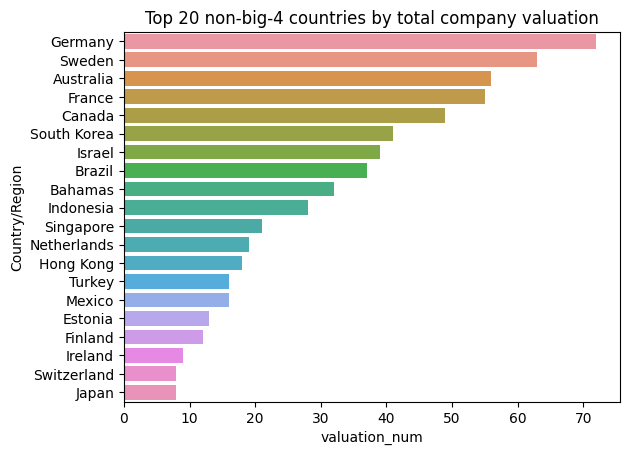

In [40]:
# Create a barplot to compare the top 20 non-big-4 countries with highest company valuations
sns.barplot(data=national_valuations_no_big4.head(20),
            y='Country/Region',
            x='valuation_num')
plt.title('Top 20 non-big-4 countries by total company valuation')
plt.show();

### Plot maps

Your investor has also asked for a global valuation map of all countries except `United States`, `China`, `India`, and `United Kingdom` (a.k.a. "big-four countries").

You have learned about using [`scatter_geo()`](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo) from the `plotly.express` library to create plot data on a map. Create a `scatter_geo()` plot that depicts the total valuations of each non-big-four country on a world map, where each valuation is shown as a circle on the map, and the size of the circle is proportional to that country's summed valuation.

**NOTE:** The output of the following code is a dynamic plot that requires you to run the code to display it. To do this, go to the Cell menu at the top of the page and select Run All.

In [41]:
# Plot the sum of valuations per country.

data = national_valuations_no_big4

px.scatter_geo(data, 
               locations='Country/Region', 
               size='valuation_num', 
               locationmode='country names', 
               color='Country/Region',
               title='Total company valuations by country (non-big-four)')

**Question: How is the valuation sum per country visualized in the plot?**
- Valuation sum per country is visualized by the size of circles around the map.

**Question: Does any region stand out as having a lot of activity?**
- Europe has a lot of unicorn companies in a concentrated area.

## Conclusion

**What are some key takeaways that you learned during this lab?**
* Missing data is a common problem for data professionals anytime they work with a data sample.
* Addressing missing values is a part of the data-cleaning process and an important step in EDA. 
* Address missing values by either removing them or filling them in.
* When considering how to address missing values, keep in mind the business, the data, and the questions to be answered. Always ensure you are not introducing bias into the dataset. 
* Addressing the missing values enabled you to answer your investor's questions. 

**How would you present your findings from this lab to others? Consider the information you would provide (and what you would omit), how you would share the various data insights, and how data visualizations could help your presentation.**
* For the industry specific companies in certain locations, you could provide a short list of company names and locations.
* For the top 20 countries by sum of valuations, you could use the plot you created in this lab or share a list. 
- For the top 20 countries sorted by sum of company valuations in each country, you would exclude `United States`, `China`, `India`, and `United Kingdom`. 
* For the questions concerning the valuation map, in addition to your visuals, you would provide a short summary of the data points. This is because the investor did not request a further breakdown of this data. 


**Reference**

[Bhat, M.A. *Unicorn Companies*](https://www.kaggle.com/datasets/mysarahmadbhat/unicorn-companies)